# Time Series Analysis

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Exploring Bike Sharing data

In [120]:
# get the "Bike Sharing" dataset from OpenML
bike_sharing = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
df = bike_sharing.frame
df.shape

(17379, 13)

In [121]:
df.describe()
# the count variable is the number of rental bikes per hour (our target)

,year,month,hour,weekday,temp,feel_temp,humidity,windspeed,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.502561,6.537775,11.546752,3.003683,20.376474,23.788755,0.627229,12.736540,189.463088
std,0.500008,3.438776,6.914405,2.005771,7.894801,8.592511,0.192930,8.196795,181.387599
min,0.000000,1.000000,0.000000,0.000000,0.820000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.000000,6.000000,1.000000,13.940000,16.665000,0.480000,7.001500,40.000000
50%,1.000000,7.000000,12.000000,3.000000,20.500000,24.240000,0.630000,12.998000,142.000000
75%,1.000000,10.000000,18.000000,5.000000,27.060000,31.060000,0.780000,16.997900,281.000000
max,1.000000,12.000000,23.000000,6.000000,41.000000,50.000000,1.000000,56.996900,977.000000


[Text(0.5, 1.0, 'Average hourly bike demand during the week'),
 [Text(0, 0, 'Sun'),
  Text(24, 0, 'Mon'),
  Text(48, 0, 'Tue'),
  Text(72, 0, 'Wed'),
  Text(96, 0, 'Thu'),
  Text(120, 0, 'Fri'),
  Text(144, 0, 'Sat')],
 Text(0.5, 0, 'Time of the week'),
 Text(0, 0.5, 'Number of bike rentals')]

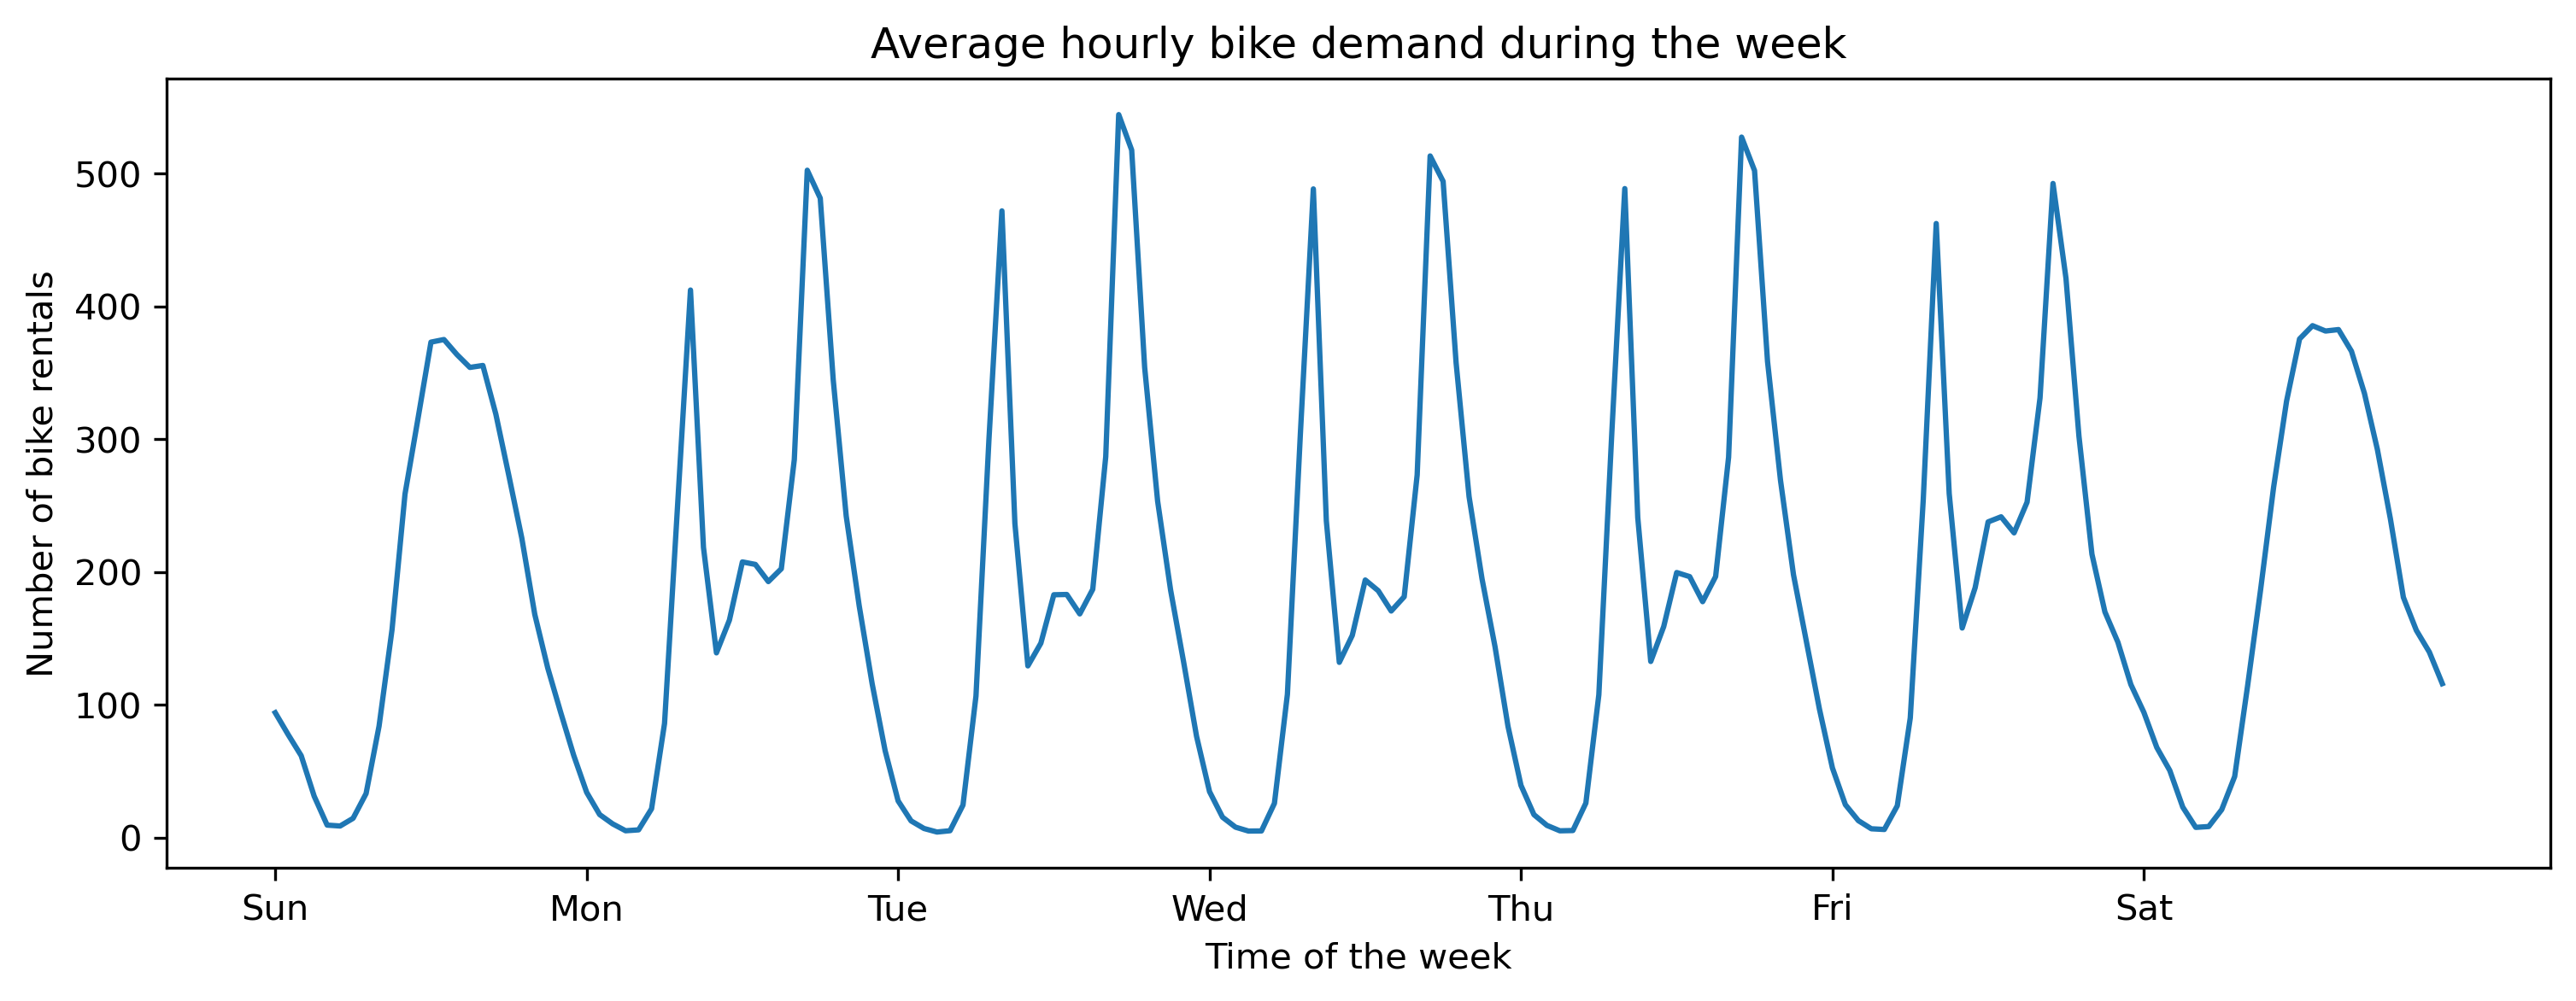

In [122]:
# plot the data for an average week

fig, ax = plt.subplots(figsize=(12, 4))
#average_week_demand = df.groupby(["weekday", "hour"]).mean()["count"]
average_week_demand = df.groupby(["weekday", "hour"])["count"].mean()
average_week_demand.head()
average_week_demand.plot(ax=ax)
ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

In [94]:
X = df
y = X.pop("count")

In [95]:
# exploration
X["season"].value_counts()

season
fall      4496
summer    4409
spring    4242
winter    4232
Name: count, dtype: int64

In [96]:
X["weather"].value_counts()

weather
clear         11413
misty          4544
rain           1419
heavy_rain        3
Name: count, dtype: int64

In [97]:
# data cleaning
X["weather"] = X["weather"].astype(str).replace("heavy_rain", "rain").astype("category")

X["weather"].value_counts()

weather
clear    11413
misty     4544
rain      1422
Name: count, dtype: int64

# Time-based cross-validation

In [99]:
from sklearn.model_selection import TimeSeriesSplit

# Note: 
# the gap parameter allows us to excluded the last 48 hours of the training period
# we use a fixed training set size
tss = TimeSeriesSplit(n_splits=5,gap=48,max_train_size=10000,test_size=1000)

for train, test in tss.split(X, y):
    print(len(train),len(test))

10000 1000
10000 1000
10000 1000
10000 1000
10000 1000


# Encoding of categorical temporal variables

In [100]:
# data preparation 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

categorical_columns = [
    "weather",
    "season",
    "holiday",
    "workingday",
]

categories = [
    ["clear", "misty", "rain"],
    ["spring", "summer", "fall", "winter"],
    ["False", "True"],
    ["False", "True"],
]

ordinal_encoder = OrdinalEncoder(categories=categories)

cT = ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough"
)

X2 = cT.fit_transform(X)

In [101]:
# let's check how it looks now
pd.DataFrame(X2,columns=X.columns).describe()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.425111,1.501640,0.028770,0.682721,0.502561,6.537775,11.546752,3.003683,20.376474,23.788755,0.627229,12.736540
std,0.638796,1.106918,0.167165,0.465431,0.500008,3.438776,6.914405,2.005771,7.894801,8.592511,0.192930,8.196795
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.820000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,6.000000,1.000000,13.940000,16.665000,0.480000,7.001500
50%,0.000000,2.000000,0.000000,1.000000,1.000000,7.000000,12.000000,3.000000,20.500000,24.240000,0.630000,12.998000
75%,1.000000,2.000000,0.000000,1.000000,1.000000,10.000000,18.000000,5.000000,27.060000,31.060000,0.780000,16.997900
max,2.000000,3.000000,1.000000,1.000000,1.000000,12.000000,23.000000,6.000000,41.000000,50.000000,1.000000,56.996900


In [102]:
# model building: we use a linear regression model
from sklearn.linear_model import RidgeCV

model = RidgeCV(alphas=np.logspace(-6, 6, 25))

In [103]:
# model evaluation
from sklearn.model_selection import cross_validate
def evaluate(model, X, y):
    ret = cross_validate(model, X, y, cv=tss, scoring=["neg_root_mean_squared_error"])
    rmse = -ret["test_neg_root_mean_squared_error"]
    print("%.2f ± %.2f" % (rmse.mean(), rmse.std()))

In [104]:
evaluate(model, X2, y)

180.63 ± 19.49


# One-hot encoding of periodic temporal variables

In [105]:
# try a different encoding of "hour", "weekday", "month"
# as separate one-hot variables

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

cT = ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
            ("one_hot_time", one_hot_encoder, ["hour", "weekday", "month"]),
        ],
        remainder="passthrough"
)

X2 = cT.fit_transform(X)

In [106]:
evaluate(model, X2, y)
# A significantly better fit

127.68 ± 10.39


# Trigonometric encoding of periodic temporal variables

In [107]:
from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

cT = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("month_sin", sin_transformer(12), ["month"]),
        ("month_cos", cos_transformer(12), ["month"]),
        ("weekday_sin", sin_transformer(7), ["weekday"]),
        ("weekday_cos", cos_transformer(7), ["weekday"]),
        ("hour_sin", sin_transformer(24), ["hour"]),
        ("hour_cos", cos_transformer(24), ["hour"]),
    ],
    remainder="passthrough"
)
X2 = cT.fit_transform(X)

In [108]:
evaluate(model, X2, y)
# wors than one-hot, but better than ordinal encoding

161.92 ± 19.30


## Spline encoding of periodic temporal variables

In [109]:
from sklearn.preprocessing import SplineTransformer

def periodic_spline_transformer(period, n_splines):
    degree = 3
    n_knots = n_splines + 1  # since include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

cT = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("cyclic_month", periodic_spline_transformer(12, n_splines=5), ["month"]),
        ("cyclic_weekday", periodic_spline_transformer(7, n_splines=6), ["weekday"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=24), ["hour"]),
    ],
    remainder="passthrough"
)
X2 = cT.fit_transform(X)

In [110]:
evaluate(model, X2, y)
# slightly better than one-hot encoding

126.90 ± 12.50


## Timeseries Analysis with Prophet

In [112]:
# see also: https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet
# and also: https://medium.com/data-science/getting-started-predicting-time-series-data-with-facebook-prophet-c74ad3040525
# prophet needs a timestamp variable which would have to be generated in the bike sharing dataset

from prophet import Prophet
import pandas as pd
from sklearn.model_selection import cross_validate
from statsmodels.tsa.seasonal import seasonal_decompose

In [113]:
# "Air_Traffic_Passenger_Statistics" dataset from kaggle
# Source: https://www.kaggle.com/datasets/nilesh2042/air-traffic-passenger-trends-usa-20052024?resource=download
train = pd.read_csv('Air_Traffic_Passenger_Statistics.csv')


train["datetime"] = train["Activity Period Start Date"].copy()
train["datetime"] = pd.to_datetime(train["datetime"])
train = train[["datetime", "Passenger Count"]].copy()

# rename columns for Prophet
train = train.rename(columns={'datetime': 'ds',
                            'Passenger Count': 'y'})

# ensure monthly data/sums
train.set_index("ds", inplace=True)
train = train.resample('ME').sum()

train["ds"] = train.index

train

,y,ds
ds,,
1999-07-31,3976746,1999-07-31
1999-08-31,3972694,1999-08-31
1999-09-30,3341964,1999-09-30
1999-10-31,3468846,1999-10-31
1999-11-30,3145240,1999-11-30
...,...,...
2025-01-31,4025815,2025-01-31
2025-02-28,3544840,2025-02-28
2025-03-31,4276931,2025-03-31


In [114]:
# Ensure datetime index is properly formatted
train.index = pd.to_datetime(train.index)

# Split into train and test
# cut off corona years and create test dataset
test = train[(train.index >= '2018-01-01') & (train.index < '2020-01-01')].copy()
train = train[train.index < '2018-01-01'].copy()

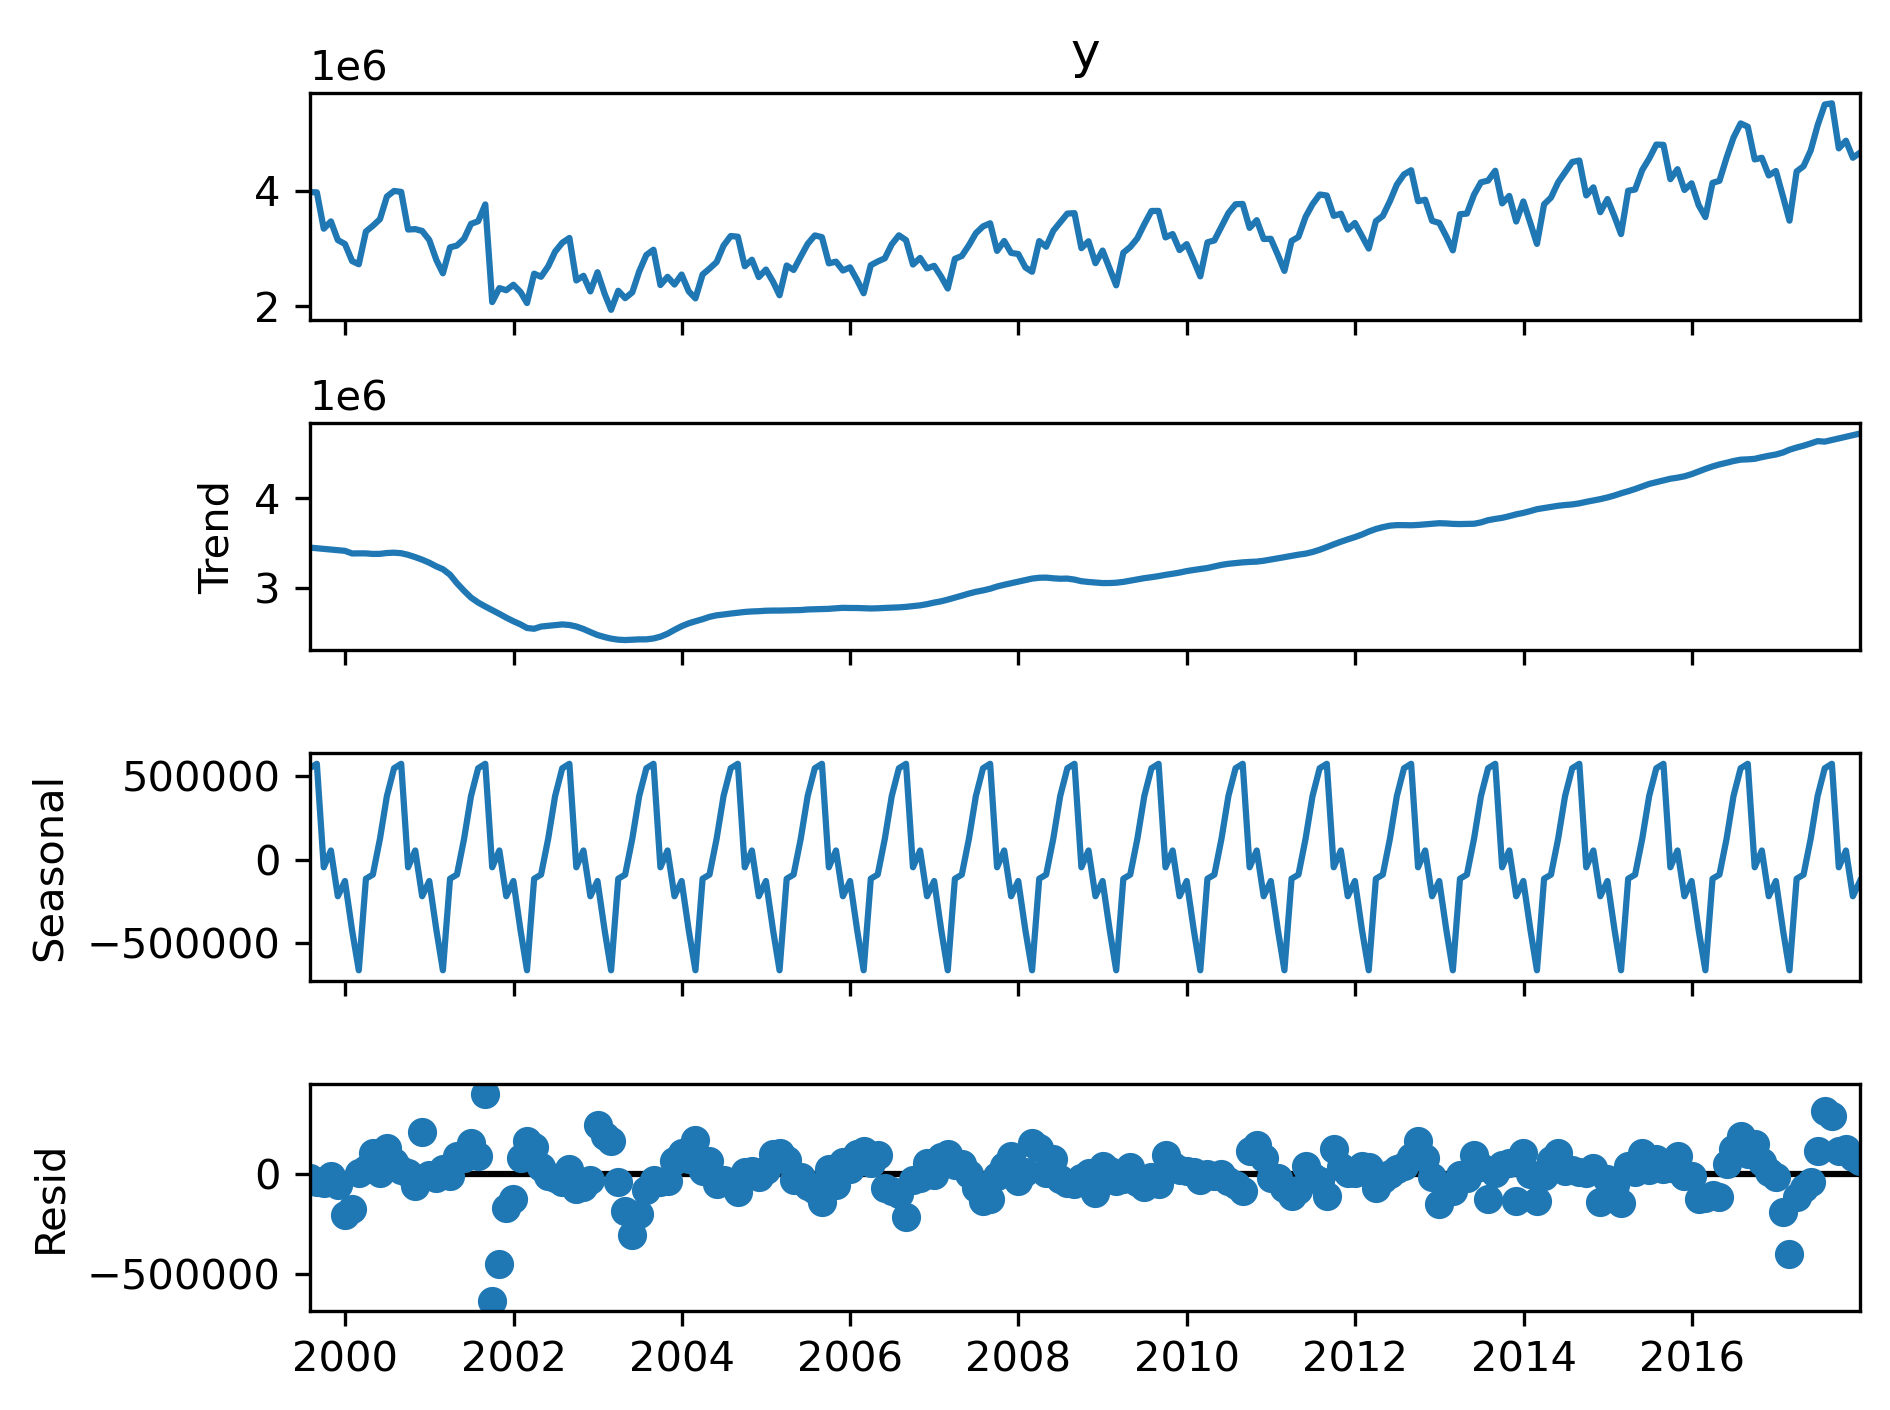

In [115]:
# visual impression of time series by decomposing
decompose = seasonal_decompose(train['y'], model='additive', extrapolate_trend='freq', period=12)
decompose.plot();

In [116]:
# train model
model_prophet  = Prophet()
model_prophet.fit(train)

15:00:39 - cmdstanpy - INFO - Chain [1] start processing


15:00:40 - cmdstanpy - INFO - Chain [1] done processing


In [117]:
# create dates for which predictions are made
df_future = model_prophet.make_future_dataframe(periods=24, freq='MS')

# make actual predictions
forecast_prophet = model_prophet.predict(df_future)
forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
241,2019-08-01,5647058.0,5464779.0,5836226.0
242,2019-09-01,5712868.0,5522944.0,5902303.0
243,2019-10-01,5057377.0,4867974.0,5234720.0
244,2019-11-01,5161474.0,4956952.0,5341478.0
245,2019-12-01,4937998.0,4767701.0,5117570.0


/Users/nyfe/anaconda3/envs/MLCO2_test/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/nyfe/anaconda3/envs/MLCO2_test/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


Text(302.66666666666663, 0.5, 'Passenger Count')

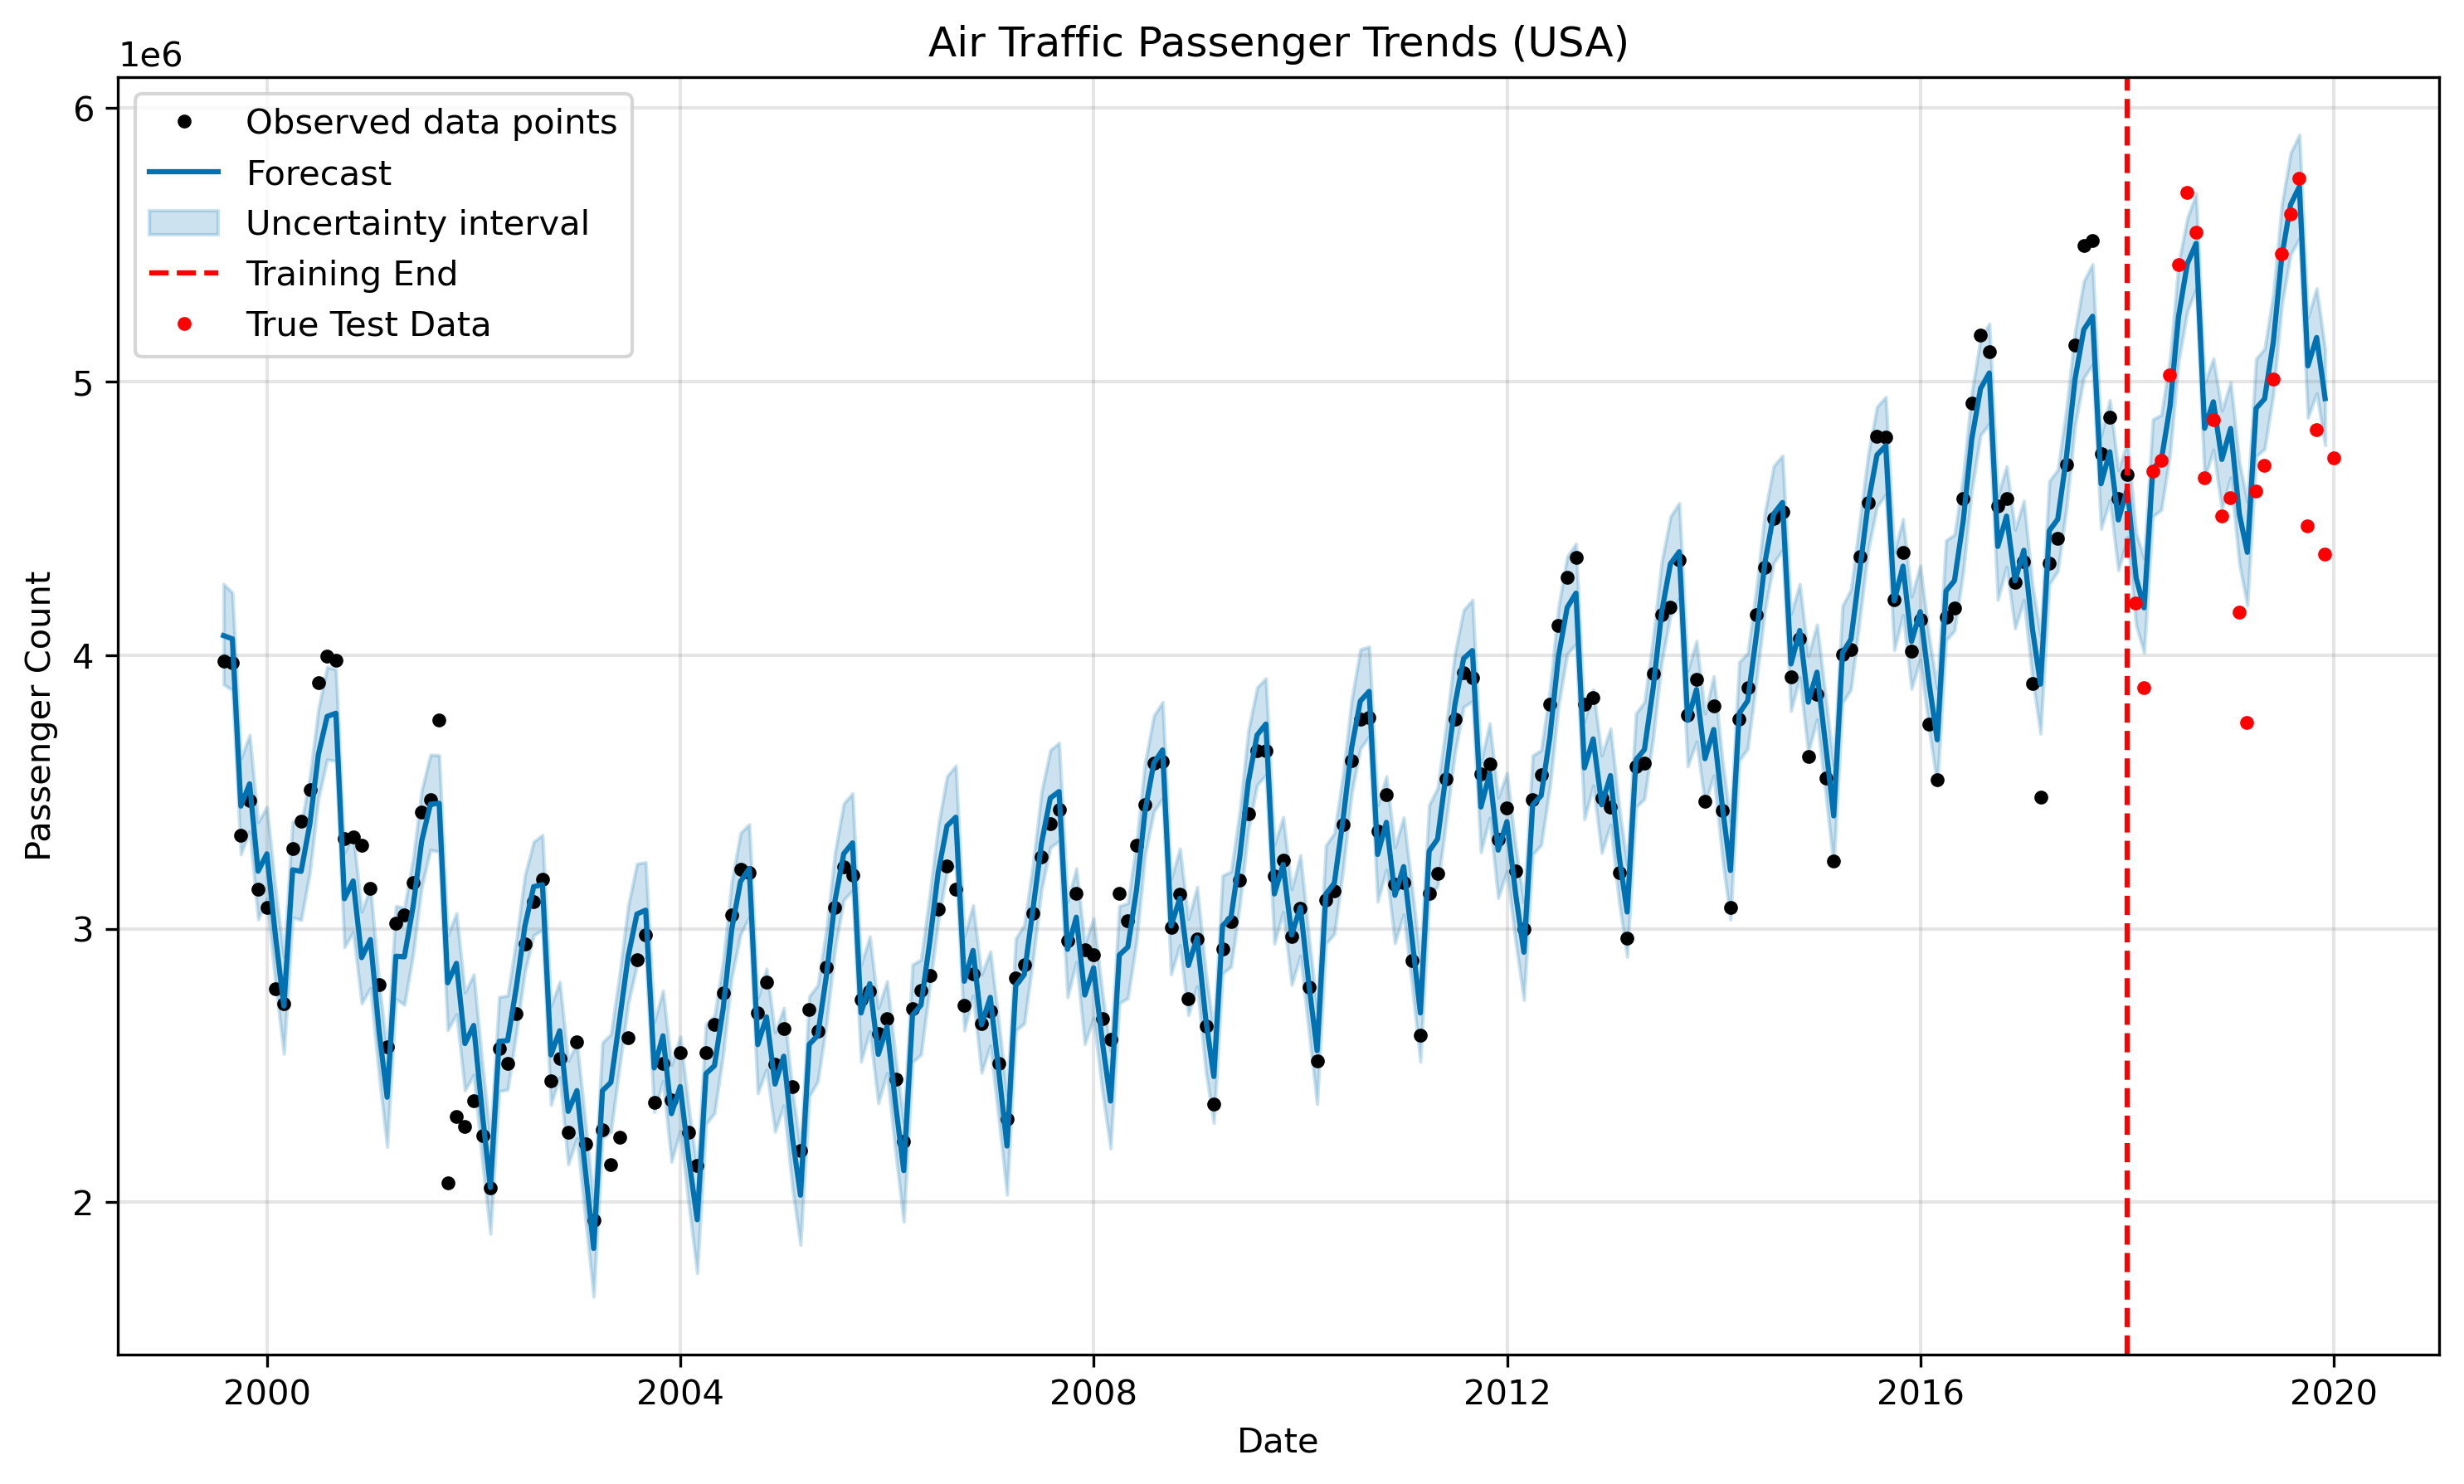

In [118]:
# plot the time series
forecast_plot = model_prophet.plot(forecast_prophet)

# add a vertical line at the end of the training period
axes = forecast_plot.gca()
last_training_date = forecast_prophet['ds'].iloc[-24]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')

# plot true test data for the period after prediction
test['ds'] = pd.to_datetime(test['ds'])
plt.plot(test['ds'], test['y'],'ro', markersize=3, label='True Test Data')

plt.legend()
plt.title('Air Traffic Passenger Trends (USA)')
plt.xlabel('Date')
plt.ylabel('Passenger Count')